<a href="https://colab.research.google.com/github/a798645635/CADD/blob/main/DNN_random_fingerprint_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, LeaveOneOut
from sklearn.metrics import (make_scorer, accuracy_score, precision_score,
                             recall_score, matthews_corrcoef,roc_curve, auc)
import sklearn.metrics
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
###编码
def encode(arr):
    arr = np.array(arr).reshape(len(arr),-1)
    enc = OneHotEncoder()
    enc.fit(arr)
    target = enc.transform(arr).toarray()
    return target

In [ ]:
##定义函数
###预处理
#倒数三行不读入描述符
columns_backward=-3
def prepare(data_path,activity_name):
    data = pd.read_csv(data_path)
    data_copy = copy.deepcopy(data)
    x_df = data_copy.iloc[:,:columns_backward]
    y_df = data_copy[str(activity_name)]
    x_arr = x_df.values
    y_arr = y_df.values
    y_arr = encode(y_arr)
    x = torch.tensor(x_arr).float()
    y = torch.tensor(y_arr).float()
    return x,y

In [ ]:
###解码
def decode(arr):
    l = []
    for i in range(len(arr)):
        if arr[i][0] > 0.5:
            l.append(1)
        elif arr[i][0] < 0.5:
            l.append(0)
        else:
            l.append('error')
    return l

In [ ]:
###计算正确个数
def accuracy(y_pred,y_true):
    acc_amount = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_true[i]:
            acc_amount += 1
        else:
            continue
    return acc_amount

In [ ]:
###用于训练网络                
def fit(model, loss_func, optimizer, train_loader, test_loader, save_path, epochs, cuda=True, *device):
    train_losses = []
    test_losses = []
    x_epoch = []
    y_tr_acc = []
    y_te_acc = []
    te_acc = []
    for epoch in range(epochs):
        acc_amount_tr = 0
        train_amount = 0
        acc_amount_te = 0
        test_amount = 0
        train_loss = 0
        test_loss = 0
        for i, data in enumerate(train_loader, 0):
            model.zero_grad()
            inputs, labels = data
            if cuda:
                inputs = inputs.to(device[0])
                labels = labels.to(device[0])
            else:
                pass
            y_pred_tr = model(inputs)
            loss = loss_func(y_pred_tr, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if cuda:
                y_pred_tr = y_pred_tr.to('cpu')
                labels = labels.to('cpu')
            else:
                pass
            y_pred_arr_tr = y_pred_tr.data.numpy().tolist()
            l_pred_tr = decode(y_pred_arr_tr)
            l_labels_tr = decode(labels)
            acc_batch_tr = accuracy(l_pred_tr, l_labels_tr)
            acc_amount_tr += acc_batch_tr
            train_amount += len(l_labels_tr)
        acc_tr = (acc_amount_tr / train_amount) * 100
        train_losses.append(train_loss / len(train_loader))
        
        with torch.no_grad():
            model.eval()
            for j, data in enumerate(test_loader, 0):
                inputs, labels = data
                if cuda:
                    inputs = inputs.to(device[0])
                else:
                    pass
                y_pred_te = model(inputs)
                loss = loss_func(y_pred_te, labels)
                test_loss += loss.item()
                
                if cuda:
                    y_pred_te = y_pred_te.to('cpu')
                else:
                    pass
                y_pred_arr_te = y_pred_te.data.numpy().tolist()
                l_pred_te = decode(y_pred_arr_te)
                l_labels_te = decode(labels)
                acc_batch_te = accuracy(l_pred_te, l_labels_te)
                acc_amount_te += acc_batch_te
                test_amount += len(l_labels_te)
        acc_te = (acc_amount_te / test_amount) * 100
        te_acc.append(acc_te)
        max_acc_te = max(te_acc)
        test_losses.append(test_loss / len(test_loader))
        print(epoch,'test_acc:%.2f'%acc_te,'%\n',
              'Maximum accuracy of test:%.2f'%max_acc_te,'% in epoch',te_acc.index(max_acc_te))
        model_path =save_path+'\\'+str(epoch)+r".pth"
        torch.save(model,model_path)
        x_epoch.append(epoch)
        y_tr_acc.append(acc_tr)
        y_te_acc.append(acc_te)
        plt.figure(figsize=(8,4))
        plt.plot(x_epoch,y_tr_acc,label='train_acc',color='blue',lw=1)
        plt.plot(x_epoch,y_te_acc,label='test_acc',color='green',lw=1)
        plt.xlabel('epoch')
        plt.ylabel(r'acc/%')
        plt.title('Epoch-Accuracy_rate')
        plt.ylim(50,100)
        plt.grid()
        plt.legend(loc='lower right')
        plt.show()
    return train_losses, test_losses


In [ ]:
###用于输出最优模型指标        
def model_pred(best_model,loader,cuda=True,*device):
    with torch.no_grad():
        l_labels = []
        l_y_pred = []
        l_y_score = []
        for inputs,labels in loader:
            if cuda == True:
                inputs = inputs.to(device[0])
            else:
                pass
            y_pred = best_model(inputs)
            if cuda == True:
                y_pred = y_pred.to('cpu')
            else:
                pass
            y_pred = y_pred.numpy().tolist()
            for i in range(len(y_pred)):
                l_y_score.append(y_pred[i][0])
            l_batch_pred = decode(y_pred)
            l_y_pred += l_batch_pred
            l_batch_labels = decode(labels)
            l_labels += l_batch_labels
    return l_labels,l_y_pred,l_y_score

In [ ]:
###用于计算SE以及SP
def SE_and_SP(conf_mat):
        TP = conf_mat[1][1]
        TN = conf_mat[0][0]
        FP = conf_mat[0][1]
        FN = conf_mat[1][0]
        SE = TP/(TP+FN)
        SP = TN/(FP+TN)
        return SE,SP

In [ ]:
###用于计算模型指标
def report(y_true,y_pred,score,title):
    report = sklearn.metrics.classification_report(y_true,y_pred)
    print(title,'report:\n',report)
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true,y_pred)
    print(title,'confusion_matrix:\n',confusion_matrix)
    mcc = matthews_corrcoef(y_true, y_pred)
    SE,SP = SE_and_SP(confusion_matrix)
    acc = accuracy_score(y_pred,y_true)*100
    print(str(title)+'_acc: %.2f'%acc,'%\n',
          str(title)+'_mcc: %.3f'%mcc,'\n',
          str(title)+'_SE: %.3f'%SE,'\n',
          str(title)+'_SP: %.3f'%SP)

    fpr,tpr,train_thresholds = sklearn.metrics.roc_curve(y_true,score)
    AUC = sklearn.metrics.auc(fpr, tpr)
    l=[acc,mcc,AUC,confusion_matrix,SE,SP]
    output=pd.DataFrame(l,index=["{}_Accuracy".format(title),"{}_MCC".format(title),"{}_AUC".format(title),"{}_confusion_matrix".format(title),"{}_SE".format(title),"{}_SP".format(title)]).T
    return output

In [ ]:
###用于返回预测错误的化合物在数据集中的位置   
def get_wrong(model,X_tensor,y_tensor,cuda=True,*device):
    with torch.no_grad():
        if cuda == True:
            y_pred = model(X_tensor.to(device[0]))
        else:
            y_pred = model(X_tensor)
        y_pred = decode(y_pred)
        y_true = decode(y_tensor)
        dif = []
        for i in range(len(y_pred)):
            if y_pred[i] == y_true[i]:
                continue
            else:
                dif.append(i)
    return dif

In [ ]:
#-----------------------------------------------------------------------------#
##读取数据,数据预处理
#
train_path=r"/content/drive/MyDrive/data/MACCSKeysFingerprint_SOM_tr描述符缩减至70.csv"
test_path=r"/content/drive/MyDrive/data/MACCSKeysFingerprint_SOM_te描述符缩减至70.csv"
X_train,y_train = prepare(train_path,'y')
train_data = pd.read_csv(train_path)
X_test,y_test = prepare(test_path,'y')
#-----------------------------------------------------------------------------#
##构造数据集以及加载器      
train_dataset = TensorDataset(X_train,y_train)
test_dataset = TensorDataset(X_test,y_test)
train_loader = DataLoader(dataset=train_dataset,batch_size=48,shuffle=True,num_workers=0)#shuffle = True可能报错,也可能因为num_works != 0报错
test_loader = DataLoader(dataset=test_dataset,batch_size=48,shuffle=True,num_workers=0)

In [ ]:
##定义网络
# ecfp4    
class MyNet(nn.Module):
    #调试此处神经元个数 为输入描述符个数
    def __init__(self,inputs):
        super(MyNet,self).__init__()
        self.fc_1 = nn.Linear(len(X_train[0]),312)
        self.bn_1 = nn.BatchNorm1d(312)
        self.fc_2 = nn.Linear(312,51)
        self.bn_2 = nn.BatchNorm1d(51)
        self.fc_3 = nn.Linear(51,13)
        self.bn_3 = nn.BatchNorm1d(13)
        self.fc_4 = nn.Linear(13,2)

        # self.fc_1 = nn.Linear(len(X_train[0]),312)
        # self.bn_1 = nn.BatchNorm1d(312)
        # self.fc_2 = nn.Linear(312,33)
        # self.bn_2 = nn.BatchNorm1d(33)
        # self.fc_3 = nn.Linear(33,2)


    def forward(self,input_data):
        x = F.relu(self.bn_1(self.fc_1(input_data)))
        x = F.relu(self.bn_2(self.fc_2(x)))
        x = F.relu(self.bn_3(self.fc_3(x)))
        x = torch.sigmoid(self.fc_4(x))
        x = x.squeeze(-1)

        # x = F.relu(self.bn_1(self.fc_1(input_data)))
        # x = F.relu(self.bn_2(self.fc_2(x)))
        # x = torch.sigmoid(self.fc_3(x))
        # x = x.squeeze(-1)
        return x
#-----------------------------------------------------------------------------#
##>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>主函数<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

if __name__ == '__main__':
##GPU加速
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [ ]:
##定义网络
# macc  
class MyNet(nn.Module):
    #调试此处神经元个数 为输入描述符个数
    def __init__(self,inputs):
        super(MyNet,self).__init__()
        self.fc_1 = nn.Linear(len(X_train[0]),70)
        self.bn_1 = nn.BatchNorm1d(70)
        self.fc_2 = nn.Linear(70,22)
        self.bn_2 = nn.BatchNorm1d(22)
        self.fc_3 = nn.Linear(22,9)
        self.bn_3 = nn.BatchNorm1d(9)
        self.fc_4 = nn.Linear(9,2)

        # self.fc_1 = nn.Linear(len(X_train[0]),70)
        # self.bn_1 = nn.BatchNorm1d(70)
        # self.fc_2 = nn.Linear(70,16)
        # self.bn_2 = nn.BatchNorm1d(16)
        # self.fc_3 = nn.Linear(16,2)


    def forward(self,input_data):
        x = F.relu(self.bn_1(self.fc_1(input_data)))
        x = F.relu(self.bn_2(self.fc_2(x)))
        x = F.relu(self.bn_3(self.fc_3(x)))
        x = torch.sigmoid(self.fc_4(x))
        x = x.squeeze(-1)

        # x = F.relu(self.bn_1(self.fc_1(input_data)))
        # x = F.relu(self.bn_2(self.fc_2(x)))
        # x = torch.sigmoid(self.fc_3(x))
        # x = x.squeeze(-1)
        return x
#-----------------------------------------------------------------------------#
##>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>主函数<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

if __name__ == '__main__':
##GPU加速
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

0 test_acc:48.59 %
 Maximum accuracy of test:48.59 % in epoch 0


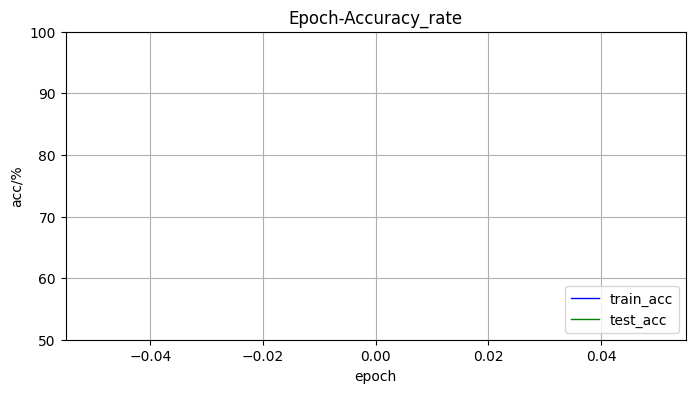

1 test_acc:69.28 %
 Maximum accuracy of test:69.28 % in epoch 1


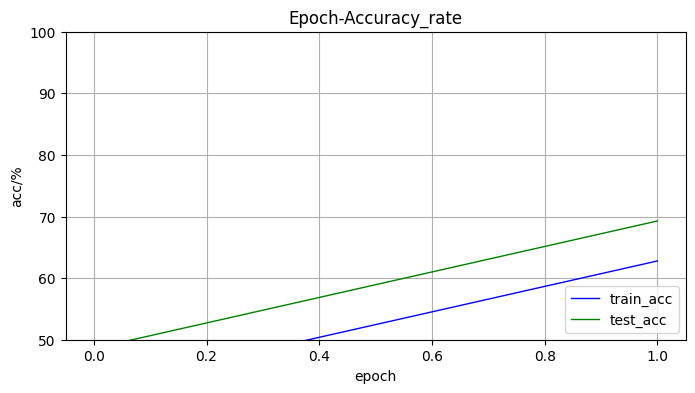

2 test_acc:68.25 %
 Maximum accuracy of test:69.28 % in epoch 1


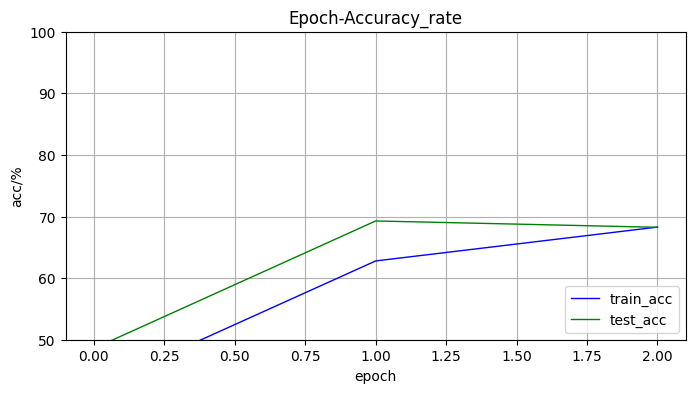

3 test_acc:68.38 %
 Maximum accuracy of test:69.28 % in epoch 1


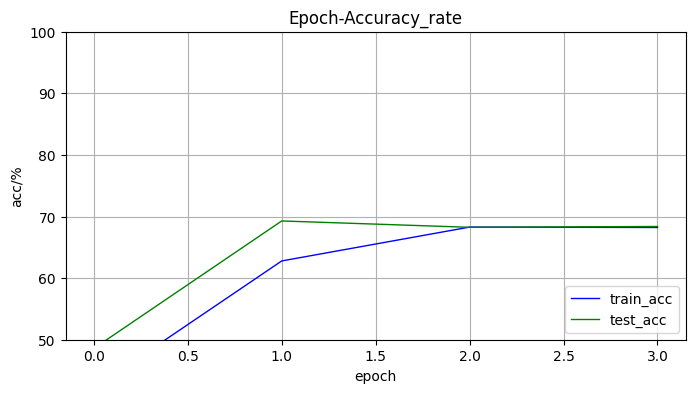

4 test_acc:74.42 %
 Maximum accuracy of test:74.42 % in epoch 4


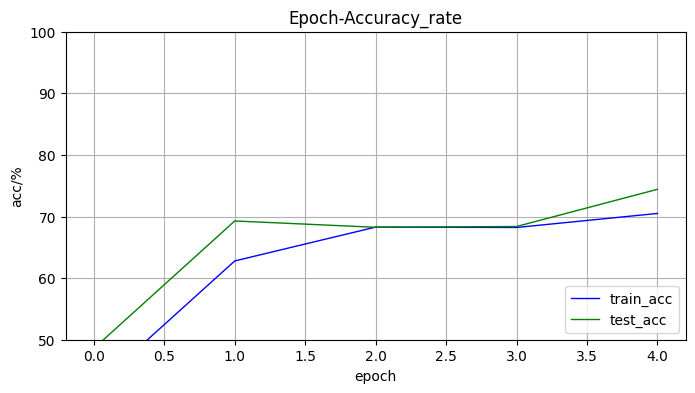

5 test_acc:81.11 %
 Maximum accuracy of test:81.11 % in epoch 5


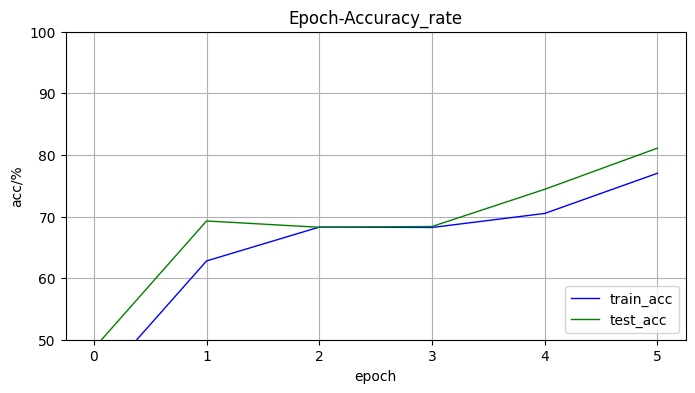

6 test_acc:82.65 %
 Maximum accuracy of test:82.65 % in epoch 6


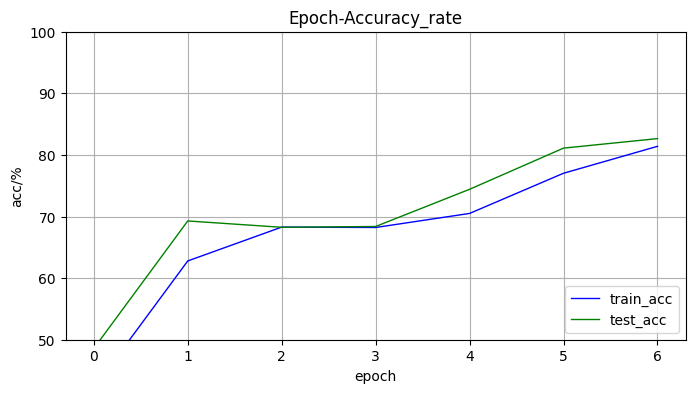

7 test_acc:84.32 %
 Maximum accuracy of test:84.32 % in epoch 7


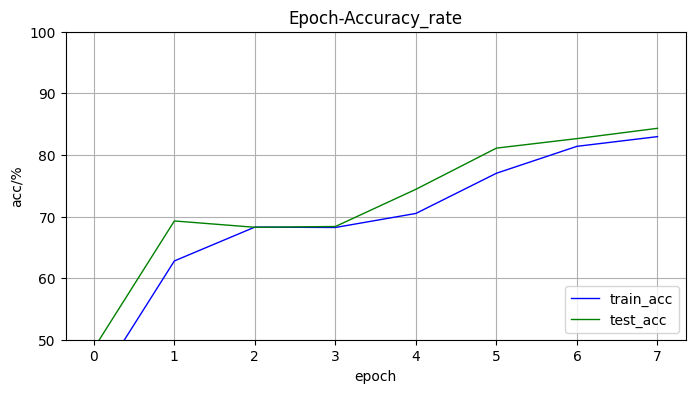

8 test_acc:84.70 %
 Maximum accuracy of test:84.70 % in epoch 8


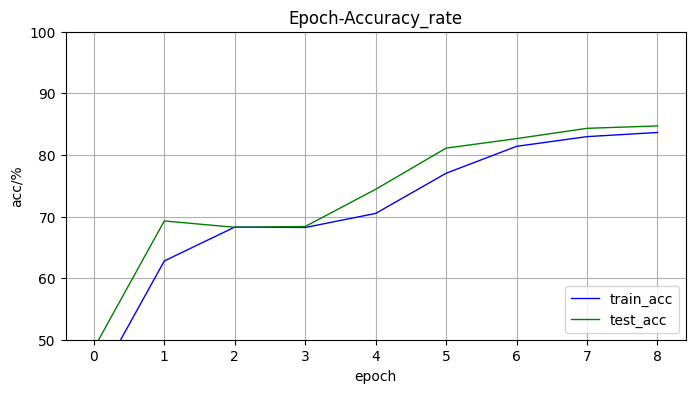

9 test_acc:85.22 %
 Maximum accuracy of test:85.22 % in epoch 9


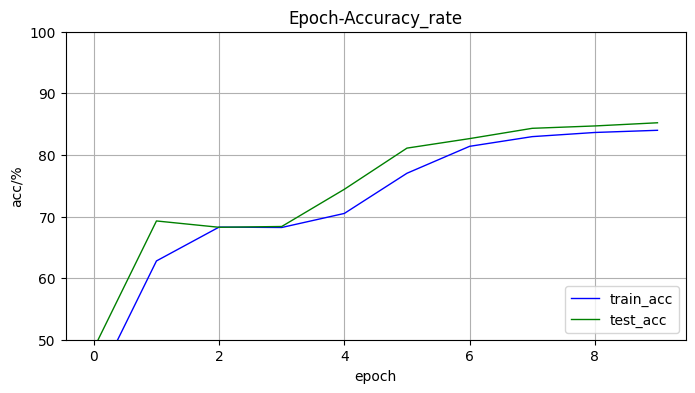

10 test_acc:84.83 %
 Maximum accuracy of test:85.22 % in epoch 9


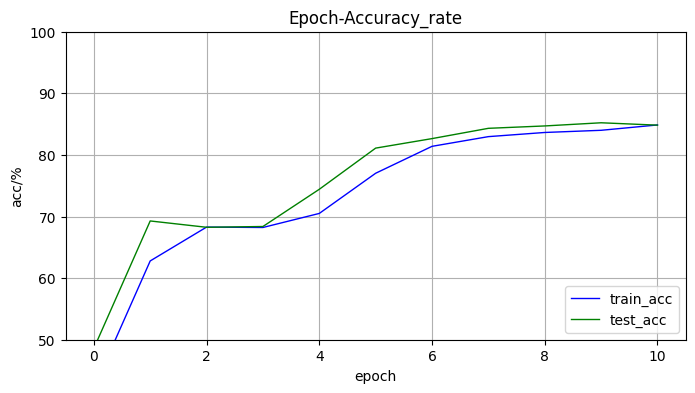

11 test_acc:85.73 %
 Maximum accuracy of test:85.73 % in epoch 11


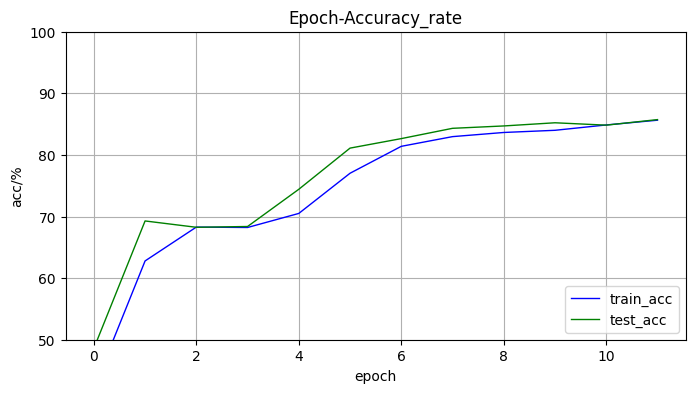

12 test_acc:85.35 %
 Maximum accuracy of test:85.73 % in epoch 11


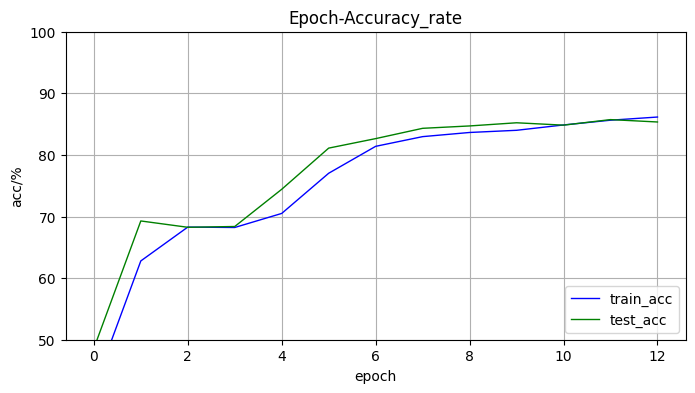

13 test_acc:85.73 %
 Maximum accuracy of test:85.73 % in epoch 11


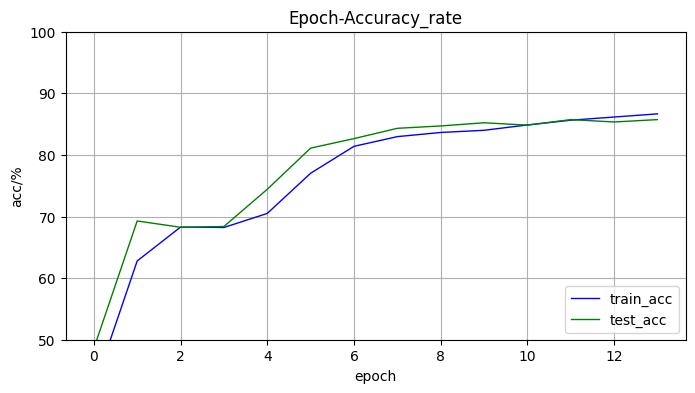

14 test_acc:87.66 %
 Maximum accuracy of test:87.66 % in epoch 14


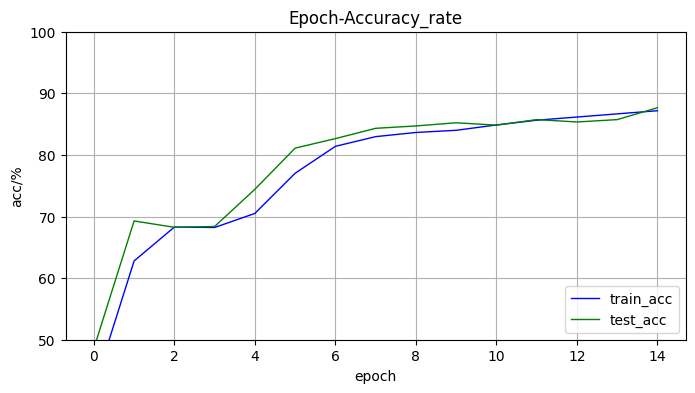

15 test_acc:87.15 %
 Maximum accuracy of test:87.66 % in epoch 14


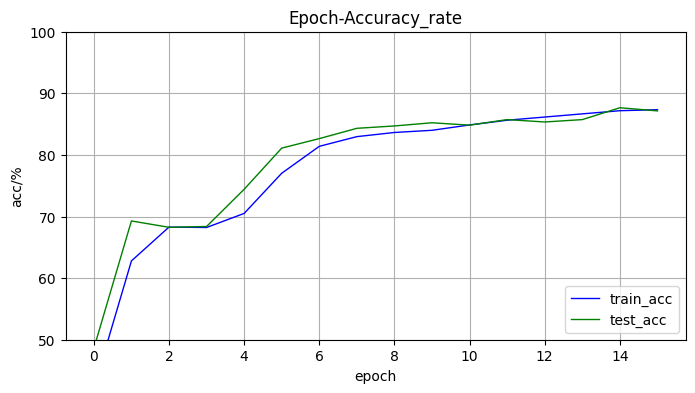

16 test_acc:86.63 %
 Maximum accuracy of test:87.66 % in epoch 14


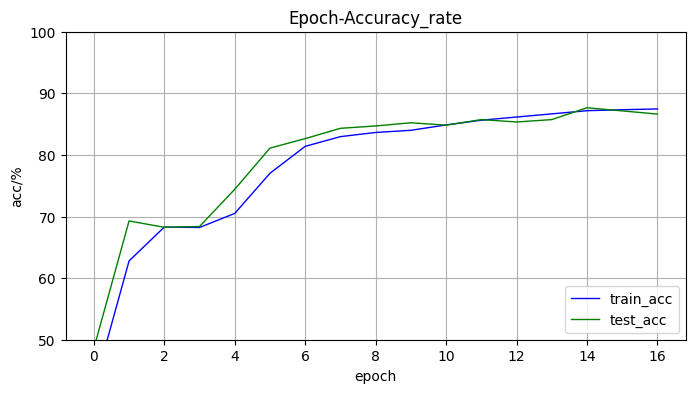

17 test_acc:86.25 %
 Maximum accuracy of test:87.66 % in epoch 14


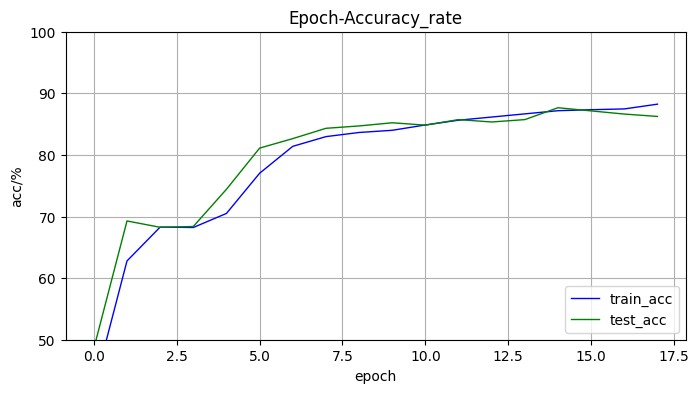

18 test_acc:83.42 %
 Maximum accuracy of test:87.66 % in epoch 14


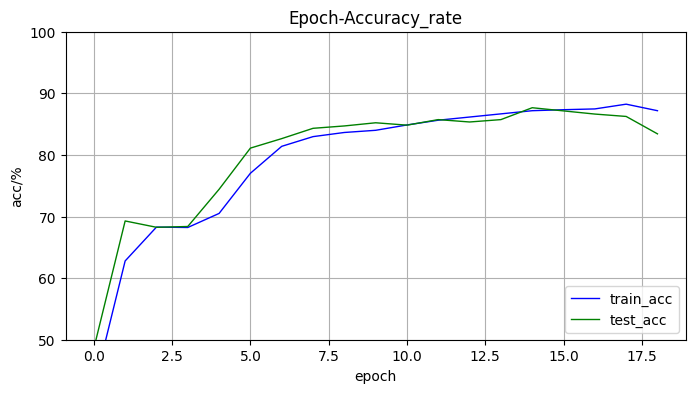

19 test_acc:86.63 %
 Maximum accuracy of test:87.66 % in epoch 14


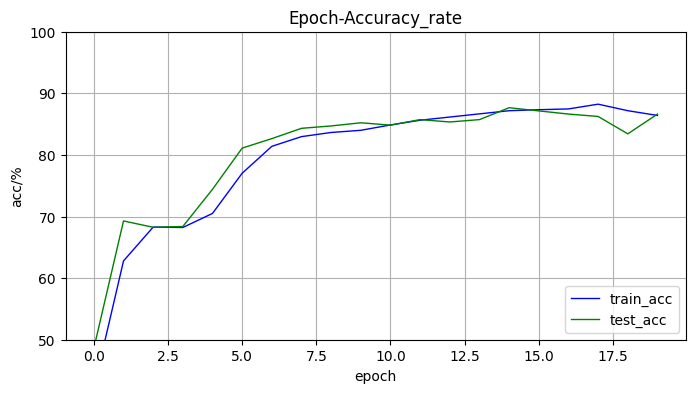

In [ ]:
##预训练
###实例化网络   
net = MyNet(X_train).to(device)
###设置优化器
# optimizer = torch.optim.Adam(net.parameters(),lr=0.0001,weight_decay=0.01)
optimizer = torch.optim.SGD(net.parameters(),lr=0.0002,weight_decay=0.01,momentum=0.99)
###定义损失函数
loss_func = torch.nn.BCELoss().to(device)
#训练,保存模型    
train_losses, test_losses =fit(net,loss_func,optimizer,train_loader,test_loader,r"/content/drive/MyDrive/dnn",20,True,device)


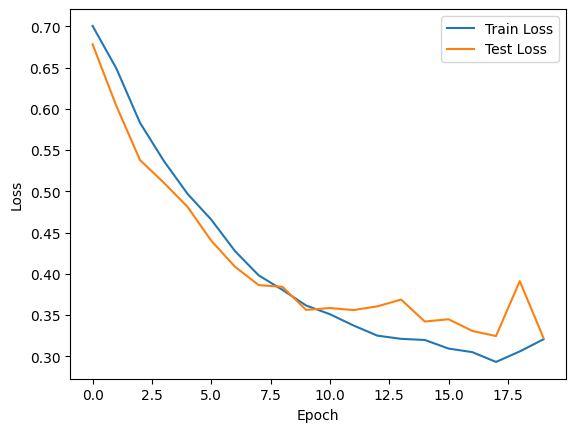

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
##重载最优模型,计算各项指标
best_net = torch.load(r"/content/drive/MyDrive/dnn/\17.pth")
print(best_net)
train_true,train_pred,train_score = model_pred(best_net,train_loader,True,device)
test_true,test_pred,test_score = model_pred(best_net,test_loader,True,device)
train_output=report(train_true,train_pred,train_score,'train')
test_output=report(test_true,test_pred,test_score,'test')

MyNet(
  (fc_1): Linear(in_features=70, out_features=70, bias=True)
  (bn_1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_2): Linear(in_features=70, out_features=22, bias=True)
  (bn_2): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_3): Linear(in_features=22, out_features=9, bias=True)
  (bn_3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_4): Linear(in_features=9, out_features=2, bias=True)
)
train report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93      2123
           1       0.87      0.80      0.83       989

    accuracy                           0.90      3112
   macro avg       0.89      0.87      0.88      3112
weighted avg       0.90      0.90      0.90      3112

train confusion_matrix:
 [[2001  122]
 [ 198  791]]
train_acc: 89.72 %
 train_mcc: 0.759 
 train_SE: 0.800 
 train_SP: 0.943
test report:
 

In [ ]:
# best_net.to(device)
# X_train.to(device)
# best_net(X_train)

In [ ]:
# import shap
# explainer = shap.DeepExplainer(best_net,X_train)
# shap_values = explainer.shap_values(X_train)
# features=train_data.columns[:-3]
# shap.summary_plot(shap_values, train_loader, feature_names=features, plot_type="bar")

In [ ]:
output=pd.concat([train_output,test_output],axis=1)
output

,train_Accuracy,train_MCC,train_AUC,train_confusion_matrix,train_SE,train_SP,test_Accuracy,test_MCC,test_AUC,test_confusion_matrix,test_SE,test_SP
0,97.111682,0.933161,0.995059,"[[2101, 23], [67, 925]]",0.93246,0.989171,87.548139,0.710052,0.926698,"[[488, 43], [54, 194]]",0.782258,0.919021


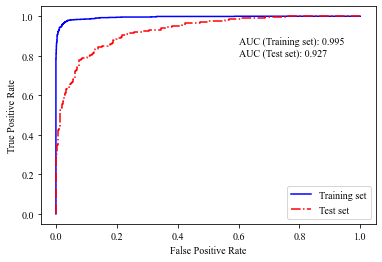

[4, 7, 14, 18, 36, 84, 89, 110, 142, 150, 176, 185, 206, 210, 211, 212, 227, 239, 308, 313, 314, 326, 336, 337, 338, 342, 344, 349, 368, 379, 380, 385, 392, 413, 416, 460, 461, 487, 489, 511, 517, 518, 529, 590, 600, 611, 621, 622, 634, 638, 639, 640, 641, 648, 650, 660, 664, 668, 669, 671, 673, 674, 675, 676, 677, 682, 684, 685, 691, 692, 693, 695, 698, 699, 700, 702, 705, 707, 709, 715, 718, 719, 720, 721, 723, 729, 730, 732, 756, 763, 764, 765, 769, 770, 771, 776, 777] 97


In [ ]:
train_fpr,train_tpr,train_thresholds = sklearn.metrics.roc_curve(train_true,train_score)
train_auc = sklearn.metrics.auc(train_fpr, train_tpr)
test_fpr,test_tpr,test_thresholds = sklearn.metrics.roc_curve(test_true,test_score)
test_auc = sklearn.metrics.auc(test_fpr,test_tpr)
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(train_fpr,train_tpr,'b',label='Training set')
plt.plot(test_fpr,test_tpr,'r',linestyle = '-.',label='Test set')
plt.text(0.6,0.8,"AUC (Training set): "+ '%0.3f'%train_auc+'\n'+"AUC (Test set): "+ '%0.3f'%test_auc)
plt.legend(loc='best')
# plt.plot([0,1],[0,1],color='black', linestyle ='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('DNN-RDK-Random')
plt.savefig(r"dnn-ran18.tif", dpi=1000, bbox_inches="tight")
plt.show()
dif = get_wrong(best_net,X_test,y_test,True,device)
print(dif,len(dif))

In [ ]:
best_net

MyNet(
  (fc_1): Linear(in_features=312, out_features=312, bias=True)
  (bn_1): BatchNorm1d(312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_2): Linear(in_features=312, out_features=51, bias=True)
  (bn_2): BatchNorm1d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_3): Linear(in_features=51, out_features=13, bias=True)
  (bn_3): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_4): Linear(in_features=13, out_features=2, bias=True)
)

In [ ]:
##输出预测错误的化合物在数据集中的位置(从0开始)
dif = get_wrong(best_net,X_test,y_test,True,device)
print(dif,len(dif))

[4, 14, 89, 110, 144, 150, 185, 210, 211, 212, 227, 239, 308, 313, 314, 319, 321, 324, 326, 336, 338, 342, 344, 349, 379, 380, 385, 392, 400, 413, 416, 460, 461, 467, 511, 518, 529, 543, 590, 600, 610, 611, 621, 622, 623, 624, 630, 631, 634, 638, 639, 640, 641, 648, 655, 656, 657, 660, 661, 664, 665, 668, 669, 671, 673, 674, 675, 676, 677, 682, 684, 685, 686, 688, 691, 692, 693, 695, 698, 699, 700, 701, 702, 705, 707, 716, 718, 720, 721, 722, 723, 729, 730, 732, 735, 746, 753, 754, 756, 763, 764, 765, 766, 769, 770, 771, 774, 776, 777] 109


In [46]:
# from sklearn.model_selection import KFold
# n_split = 5
# avg_accuracy = 0
# data = pd.read_csv(r"C:\Users\82176\Desktop\50-100-new\TT\TT_all-selected-svm-10_tr_2074.csv")
# features = list(data.columns)
# features.remove('label')
# features.remove('source')
# x = data[features]
# y = data['label']
# for train_index, test_index in StratifiedKFold(n_split,shuffle=True,random_state=5).split(x):
#     x_train, x_test = x.iloc[train_index], x.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
#     x_train_arr = x_train.values
#     y_train_arr = y_train.values
#     y_train_arr = encode(y_train_arr)
#     x_train = torch.tensor(x_train_arr).float()
#     y_train = torch.tensor(y_train_arr).float()
    
#     x_test_arr = x_test.values
#     y_test_arr = y_test.values
#     y_test_arr = encode(y_test_arr)
#     x_test = torch.tensor(x_test_arr).float()
#     y_test = torch.tensor(y_test_arr).float()
    
#     train_dataset = TensorDataset(x_train,y_train)
#     test_dataset = TensorDataset(x_test,y_test)
#     train_loader = DataLoader(dataset=train_dataset,batch_size=48,shuffle=True,num_workers=0)#shuffle = True可能报错,也可能因为num_works != 0报错
#     test_loader = DataLoader(dataset=test_dataset,batch_size=48,shuffle=True,num_workers=0)
    
#     train_true,train_pred,train_score = model_pred(best_net,train_loader,True,device)
#     test_true,test_pred,test_score = model_pred(best_net,test_loader,True,device)
#     acc = accuracy_score(train_pred,train_true)*100
#     report(test_true,test_pred,'test')
#     print(acc)
#     avg_accuracy += acc
# print("K fold average accuracy: {}".format(avg_accuracy / n_split))

In [ ]:
##重载最优模型,计算各项指标       
# =============================================================================
#     best_net = torch.load(r'E:\DNN\MACCS_som\again\3.pth')
#     print(best_net)
#     train_true,train_pred,train_score = model_pred(best_net,train_loader,True,device)
#     test_true,test_pred,test_score = model_pred(best_net,test_loader,True,device)
#     report(train_true,train_pred,'train')
#     report(test_true,test_pred,'test')
#     train_fpr,train_tpr,train_thresholds = sklearn.metrics.roc_curve(train_true,train_score)
#     train_auc = sklearn.metrics.auc(train_fpr, train_tpr)
#     test_fpr,test_tpr,test_thresholds = sklearn.metrics.roc_curve(test_true,test_score)
#     test_auc = sklearn.metrics.auc(test_fpr,test_tpr)
#     plt.figure(figsize=(12,9))
#     plt.plot(train_fpr,train_tpr,'b',label='train_AUC = %0.4f'%train_auc)
#     plt.plot(test_fpr,test_tpr,'g',label='test_AUC = %0.4f'%test_auc)
#     plt.legend(loc='lower right',fontsize=15)
#     plt.plot([0,1],[0,1],'r--')
#     plt.xlabel('False Positive Rate',size=15)
#     plt.ylabel('True Positive Rate',size=15)
#     plt.title('DNN_ROC',size=25)
#     plt.show()